In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import statistics
from scipy import stats

data = pd.read_csv ("Allsupernovae.csv") #reading in supernovae data and assigning it to a variable 'data'

cosmo = FlatLambdaCDM(H0=70, Om0=0.287) #H0 value from Betoule et al. 2014, omega_m best fit value from JLA sample, 
                                        #cosmological model assuming flat Universe

#Calculating luminosity distances for supernovae
data['d_L'] = cosmo.luminosity_distance(data.zcmb) #changing cmb redshift to distance in Mpc


#Distance modulus eq 
#mu = 5log(d_L/10pc) or bmag-absmag = mu = 5 log10(D_L) + 25 if D_L is in Mpc
data['mu'] = 5*(np.log10(data.d_L)) + 25

#best vals distance modulus
data['distance_modulus'] = data.mb - ((-19.10) - 0.117*data.X1 + 2.450*data.c)

In [7]:
#taking out null values from data frame
data = data[(data['local_SFR'].notnull())]

In [8]:
#residuals 
data['residuals'] = data.distance_modulus - data.mu
data['err'] = data.error_mb + (0.01 + ((0.117*data.error_X1) + (data.X1*0.006)) 
                          + ((2.450*data.error_c)+(data.c*0.075)))


data['upperSFR'] = data.local_SFR_upper
data['lowerSFR'] = data.local_SFR_lower

#from Betoule et al. 2014, section 5
data['upperSFR_err'] = np.where((data.local_SFR < -2.9) & (data.local_SFR_upper >= -2.9), 0.08**2, 0) #if moved from pass. to act.
data['lowerSFR_err'] = np.where((data.local_SFR > -2.9) & (data.local_SFR_lower <= -2.9), 0.08**2, 0) #if moved from act. to pass.


data['err_tot'] = data.err + data.upperSFR_err + data.lowerSFR_err

In [9]:
#splitting the sample into passive/active galaxies (-2.9 is traditional cut in SFR)
passive = data[(data.local_SFR <= -2.9)] 
residuals_passive= passive.distance_modulus - passive.mu
active = data[(data.local_SFR > -2.9)] 
residuals_active = active.distance_modulus - active.mu

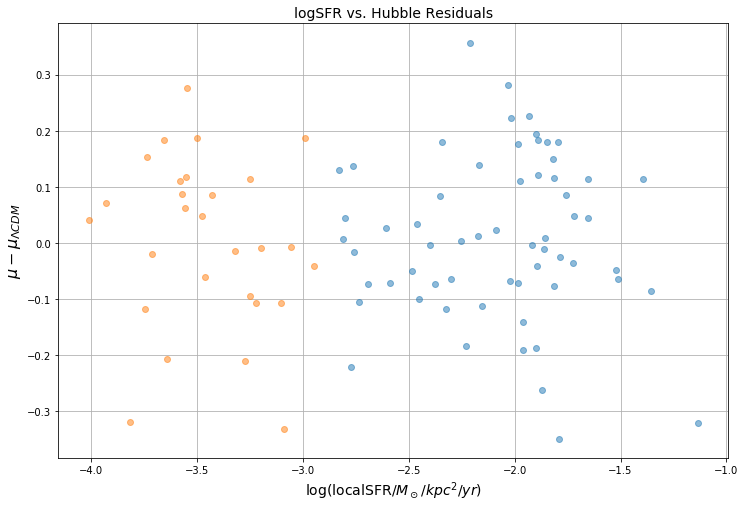

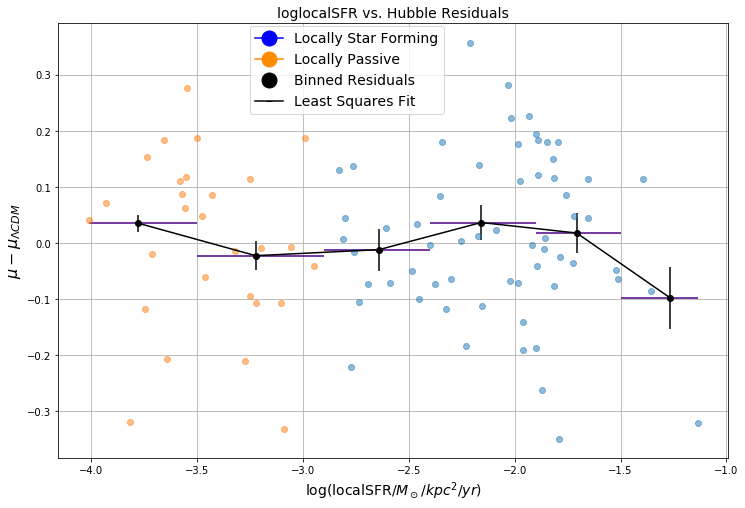

In [10]:
fig = plt.figure(figsize=(12,8))
plt.plot(active.local_SFR, residuals_active, 'o', alpha=0.5)
plt.plot(passive.local_SFR, residuals_passive, 'o', alpha=0.5)

plt.title('loglocalSFR vs. Hubble Residuals', fontsize=14)
plt.xlabel(r'log(localSFR/$M_\odot/kpc^{2}/yr$)', fontsize=14)
plt.ylabel(r'$\mu - \mu_{\Lambda CDM}$', fontsize=16)
plt.grid(True)

#bins
bin_1 = data[(data.local_SFR < -3.5)] 
bin_2 = data[(data.local_SFR >= -3.5) & (data.local_SFR < -2.9)] 
bin_3 = data[(data.local_SFR >= -2.9) & (data.local_SFR < -2.4)] 
bin_4 = data[(data.local_SFR >= -2.4) & (data.local_SFR < -1.9)] 
bin_5 = data[(data.local_SFR >= -1.9) & (data.local_SFR < -1.5)] 
bin_6 = data[(data.local_SFR >= -1.5)]

#midpoint of each bin
midpoint_1 = (max(bin_1.local_SFR) + min(bin_1.local_SFR))/2
midpoint_2 = (max(bin_2.local_SFR) + min(bin_2.local_SFR))/2
midpoint_3 = (max(bin_3.local_SFR) + min(bin_3.local_SFR))/2
midpoint_4 = (max(bin_4.local_SFR) + min(bin_4.local_SFR))/2
midpoint_5 = (max(bin_5.local_SFR) + min(bin_5.local_SFR))/2
midpoint_6 = (max(bin_6.local_SFR) + min(bin_6.local_SFR))/2

midpoint = [midpoint_1, midpoint_2, midpoint_3, midpoint_4, midpoint_5, midpoint_6]

#weight of each bin based on total errors
weight_1 = 1/(np.abs(np.average(bin_1.err_tot)))
weight_2 = 1/(np.abs(np.average(bin_2.err_tot)))
weight_3 = 1/(np.abs(np.average(bin_3.err_tot)))
weight_4 = 1/(np.abs(np.average(bin_4.err_tot)))
weight_5 = 1/(np.abs(np.average(bin_5.err_tot)))
weight_6 = 1/(np.abs(np.average(bin_6.err_tot)))

weight = [weight_1, weight_2, weight_3, weight_4, weight_5, weight_6]

#mean residuals
mean_1 = np.average(bin_1.residuals, weights = 1/bin_1.err_tot)
mean_2 = np.average(bin_2.residuals, weights = 1/bin_2.err_tot)
mean_3 = np.average(bin_3.residuals, weights = 1/bin_3.err_tot)
mean_4 = np.average(bin_4.residuals, weights = 1/bin_4.err_tot)
mean_5 = np.average(bin_5.residuals, weights = 1/bin_5.err_tot)
mean_6 = np.average(bin_6.residuals, weights = 1/bin_6.err_tot)

mean = [mean_1, mean_2, mean_3, mean_4, mean_5, mean_6]

plt.plot(midpoint, mean, 'ko', linestyle='-')

#error bars (x dir)
#right hand errors
err_1r = -3.5 - midpoint[0]
err_2r = -2.9 - midpoint[1]
err_3r = -2.4 - midpoint[2]
err_4r = -1.9 - midpoint[3]
err_5r = -1.5 - midpoint[4]
err_6r = max(bin_6.local_SFR) - midpoint[5]

err_right = [err_1r, err_2r, err_3r, err_4r, err_5r, err_6r]
             
#left hand errors
err_1l = midpoint[0] - min(bin_1.local_SFR)  
err_2l = midpoint[1] - (-3.5) 
err_3l = midpoint[2] - (-2.9) 
err_4l = midpoint[3] - (-2.4)
err_5l = midpoint[4] - (-1.9) 
err_6l = midpoint[5] - (-1.5)

err_left = [err_1l, err_2l, err_3l, err_4l, err_5l, err_6l]

asym_errx = [err_left, err_right]
plt.errorbar(midpoint[0:6], mean[0:6], xerr=asym_errx, fmt='none', color='indigo', alpha=1)

#error bars (y dir)
erry1 = statistics.stdev(bin_1.err_tot)  
erry2 = statistics.stdev(bin_2.err_tot) 
erry3 = statistics.stdev(bin_3.err_tot) 
erry4 = statistics.stdev(bin_4.err_tot) 
erry5 = statistics.stdev(bin_5.err_tot) 
erry6 = statistics.stdev(bin_6.err_tot) 


erry = [erry1, erry2, erry3, erry4, erry5, erry6]
plt.errorbar(midpoint[0:6], mean[0:6], yerr=erry, fmt='none', color='k', alpha=1)


#legend
blue_line = mlines.Line2D([], [], color='b', marker='o',markersize=15, label='Locally Star Forming')
orange_line = mlines.Line2D([], [], color='darkorange', marker='o',markersize=15, label='Locally Passive')
black_dots = mlines.Line2D([], [], color='k', marker='o', markersize=15,linestyle='none', label='Binned Residuals')
black_line = mlines.Line2D([], [], color='k', marker='_',linestyle='-', label='Least Squares Fit')
plt.legend(handles=[blue_line, orange_line, black_dots, black_line], fontsize=14, bbox_to_anchor=(0.275, 0.775))

plt.show()

fig.savefig('Delta Local SFR Fit.pdf')
plt.close(fig)

In [11]:
#with single bin either side
bin_pass = data[(data.local_SFR <= -2.9)] 
bin_act = data[(data.local_SFR > -2.9)] 
 
midpoint_pass = (max(bin_pass.local_SFR) + min(bin_pass.local_SFR))/2
midpoint_act = (max(bin_act.local_SFR) + min(bin_act.local_SFR))/2

weight_pass = 1/(np.abs(np.average(bin_pass.err_tot)))
weight_act = 1/(np.abs(np.average(bin_act.err_tot)))

mean_pass = np.average(bin_pass.residuals, weights = 1/bin_pass.err_tot)
mean_act = np.average(bin_act.residuals, weights = 1/bin_act.err_tot)

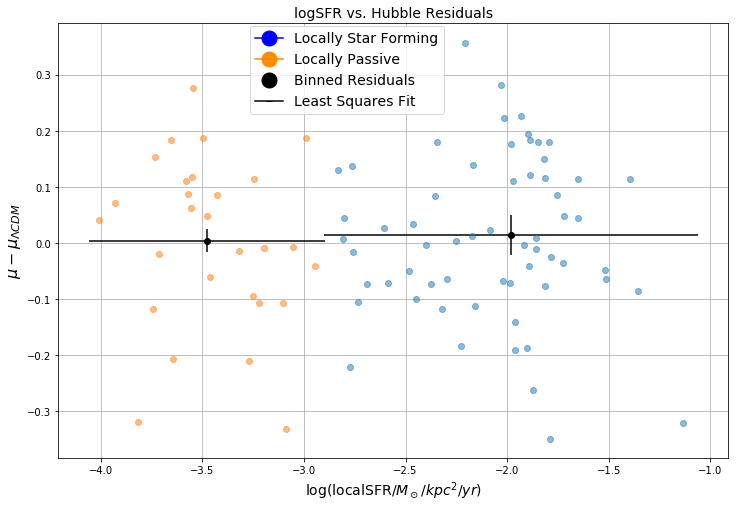

In [15]:
fig = plt.figure(figsize=(12,8))
plt.plot(active.local_SFR, residuals_active, 'o', alpha=0.5)
plt.plot(passive.local_SFR, residuals_passive, 'o', alpha=0.5)
plt.title('logSFR vs. Hubble Residuals', fontsize=14)
plt.xlabel(r'log(localSFR/$M_\odot/kpc^{2}/yr$)', fontsize=14)
plt.ylabel(r'$\mu - \mu_{\Lambda CDM}$', fontsize=16)
plt.grid(True)

plt.plot(midpoint_act, mean_act, 'ko')
plt.plot(midpoint_pass, mean_pass, 'ko')

#error bars (y dir)
pass_err = statistics.stdev(bin_pass.err_tot)
act_err = statistics.stdev(bin_act.err_tot)
plt.errorbar(midpoint_pass, mean_pass, yerr=pass_err, fmt='none', color='k', alpha=1)
plt.errorbar(midpoint_act, mean_act, yerr=act_err, fmt='none', color='k', alpha=1)

#error bars (x dir)
pass_err_x = 0.58
act_err_x = 0.92

plt.errorbar(midpoint_pass, mean_pass, xerr=pass_err_x, fmt='none', color='k', alpha=1)
plt.errorbar(midpoint_act, mean_act, xerr=act_err_x, fmt='none', color='k', alpha=1)

#legend
blue_line = mlines.Line2D([], [], color='b', marker='o',markersize=15, label='Locally Star Forming')
orange_line = mlines.Line2D([], [], color='darkorange', marker='o',markersize=15, label='Locally Passive')
black_dots = mlines.Line2D([], [], color='k', marker='o', markersize=15,linestyle='none', label='Binned Residuals')
black_line = mlines.Line2D([], [], color='k', marker='_',linestyle='-', label='Least Squares Fit')
plt.legend(handles=[blue_line, orange_line, black_dots, black_line], fontsize=14, bbox_to_anchor=(0.275, 0.775))

plt.show()
fig.savefig('Delta Local SFR Mean Fit.pdf')
plt.close(fig)

In [13]:
#step size with only one bin for active and passive
mean_pass - mean_act

-0.0095097759085930236